In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Introduction to the task: Semantic Segmentation

Semantic segmentation is a computer vision task that involves labeling each pixel in an image with a class label. Unlike image classification, where the entire image is assigned a single label, or object detection, where bounding boxes are predicted around objects, semantic segmentation aims to provide a detailed, pixel-level understanding of the scene. This means that every pixel in the image is classified as belonging to a particular category, such as "car," "tree," "road," etc.

The task is particularly important in various applications ranging from autonomous driving, where understanding the road scene in detail is crucial, to medical imaging, where precise segmentation of different tissues or anomalies could be vital for diagnosis and treatment planning. Deep learning methods, especially Convolutional Neural Networks (CNNs) like U-Net, have been highly successful in solving semantic segmentation problems due to their capacity for hierarchical feature learning.

Semantic segmentation does not distinguish between different instances of the same class (e.g., two different cars would both be labeled as "car" without identifying them as separate entities), which sets it apart from another related task known as instance segmentation.

<img src="https://cdn-images-1.medium.com/v2/resize:fit:850/1*f6Uhb8MI4REGcYKkYM9OUQ.png" width="400">

## Several necessary imports

In [22]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy
from matplotlib_inline.backend_inline import set_matplotlib_formats
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
import time

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

## Setting the seeds
In my Python code, I always make it a point to set the random seed because it ensures that the randomness in my experiments is reproducible, making debugging and collaboration easier. For instance, by setting the seed, I can guarantee that both I and anyone who runs my code will generate the same sequence of random numbers, making the results consistent and easier to validate.

In [23]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


#Data description (Vaihingen data)
The data set contains 33 patches (of different sizes), each consisting of a true orthophoto (TOP) extracted from a larger TOP mosaic. The ground sampling distance is 9 cm.
The TOP are 8 bit TIFF files with three bands; the three RGB bands of the TIFF files correspond to the near infrared, red and green bands delivered by the camera. The DSM are TIFF files with one band; the grey levels (corresponding to the DSM heights) are encoded as 32 bit float values.

Six categories/classes have been defined:

1. Impervious surfaces (RGB: 255, 255, 255)
2. Building (RGB: 0, 0, 255)
3. Low vegetation (RGB: 0, 255, 255)
4. Tree (RGB: 0, 255, 0)
5. Car (RGB: 255, 255, 0)
6. Clutter/background (RGB: 255, 0, 0)


<img src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/overview_tiles.jpg" width="400">





#Data manipulation

I performed preprocessing on the Image Dataset to make it suitable for the machine learning model. One of the key steps was image cropping: I resized all images to a uniform size of 250x250 pixels to ensure consistency and reduce computational load. I applied the same cropping technique to the corresponding labels to maintain the integrity of the dataset.

```python
# This is just Python code fencing
import cv2
import numpy as np
import os

ORIGINAL_IMGS_PATH = './data/top_imgs/'
ORIGINAL_MASKS_PATH = './data/ground_truth_masks/'

CROPPED_IMGS_PATH = './cropped_data/cropped_imgs/'
CROPPED_MASKS_PATH = './cropped_data/cropped_masks/'

# removing the last two dir in case they already exist...
if os.path.exists(CROPPED_IMGS_PATH):
    os.system('rm -r ' + CROPPED_IMGS_PATH)
if os.path.exists(CROPPED_MASKS_PATH):
    os.system('rm -r ' + CROPPED_MASKS_PATH)

# ... then create them again
os.makedirs(CROPPED_IMGS_PATH)
os.makedirs(CROPPED_MASKS_PATH)

k = 0

def crop(img, new_height, new_width,NEW_PATH, type):
    global k
    i = 0
    j = 0

    height = img.shape[0]
    width = img.shape[1]
    
    while i < height:
        cropped_image = img[i:i+new_height, j:j+new_width]
        cv2.imwrite(NEW_PATH + type + str(k) + ".tif", cropped_image)
        j += new_width
        if j >= width:
            j = 0
            i += new_height
        k += 1

# order by name images in the directory
images = sorted(os.listdir(ORIGINAL_IMGS_PATH))
masks = sorted(os.listdir(ORIGINAL_MASKS_PATH))

for image in images:
    if not image.endswith('.tif'):
        continue
    img = cv2.imread(ORIGINAL_IMGS_PATH + image)
    crop(img, 250, 250, CROPPED_IMGS_PATH,"img")
   
k = 0

for mask in masks:
    if not mask.endswith('.tif'):
        continue
    img = cv2.imread(ORIGINAL_MASKS_PATH + mask)
    crop(img, 250, 250, CROPPED_MASKS_PATH,"mask")

```

After the cropping process, I randomly split the dataset into three separate directories: `train_dataset`, `val_dataset`, and `test_dataset`. This not only enables better generalization of the model but also provides distinct sets for training, validation, and evaluation, which is crucial for understanding the model's performance.

```python
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

PATH_TO_IMGS = './cropped_data/cropped_imgs/'
PATH_TO_MASKS = './cropped_data/cropped_masks/'

PATH_TO_TRAIN_IMGS = './train/train_imgs/'
PATH_TO_TRAIN_MASKS = './train/train_masks/'

PATH_TO_VAL_IMGS = './val/val_imgs/'
PATH_TO_VAL_MASKS = './val/val_masks/'

PATH_TO_TEST_IMGS = './test/test_imgs/'
PATH_TO_TEST_MASKS = './test/test_masks/'

images = sorted(os.listdir(PATH_TO_IMGS))
masks = sorted(os.listdir(PATH_TO_MASKS))

assert len(images) == len(masks), "Number of images and masks must be equal"

# splitting the data into train, val and test sets
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

#remove the directory if it already exists
if os.path.exists(PATH_TO_TRAIN_IMGS):
    os.system('rm -r ' + PATH_TO_TRAIN_IMGS)
if os.path.exists(PATH_TO_TRAIN_MASKS):
    os.system('rm -r ' + PATH_TO_TRAIN_MASKS)

if os.path.exists(PATH_TO_VAL_IMGS):
    os.system('rm -r ' + PATH_TO_VAL_IMGS)
if os.path.exists(PATH_TO_VAL_MASKS):
   os.system('rm -r ' + PATH_TO_VAL_MASKS)  

if os.path.exists(PATH_TO_TEST_IMGS):
   os.system('rm -r ' + PATH_TO_TEST_IMGS)
if os.path.exists(PATH_TO_TEST_MASKS):
   os.system('rm -r ' + PATH_TO_TEST_MASKS)


os.makedirs(PATH_TO_TRAIN_IMGS)
os.makedirs(PATH_TO_TRAIN_MASKS)

os.makedirs(PATH_TO_VAL_IMGS)
os.makedirs(PATH_TO_VAL_MASKS)

os.makedirs(PATH_TO_TEST_IMGS)
os.makedirs(PATH_TO_TEST_MASKS)

# copy the images and masks to the corresponding directories
def copy_to_dir(images, masks, imgs_path, masks_path):
    for image, mask in zip(images, masks):
        if not image.endswith('.tif'):
            continue
        img = cv2.imread(PATH_TO_IMGS + image)
        cv2.imwrite(imgs_path + image, img)
        
        label = cv2.imread(PATH_TO_MASKS + mask)
        cv2.imwrite(masks_path + mask, label)

copy_to_dir(train_images, train_masks, PATH_TO_TRAIN_IMGS, PATH_TO_TRAIN_MASKS)
copy_to_dir(val_images, val_masks, PATH_TO_VAL_IMGS, PATH_TO_VAL_MASKS)
copy_to_dir(test_images, test_masks, PATH_TO_TEST_IMGS, PATH_TO_TEST_MASKS)


print(len(train_images),len(val_images),len(test_images))
```



#Let's look at some pictures with corresponding masks

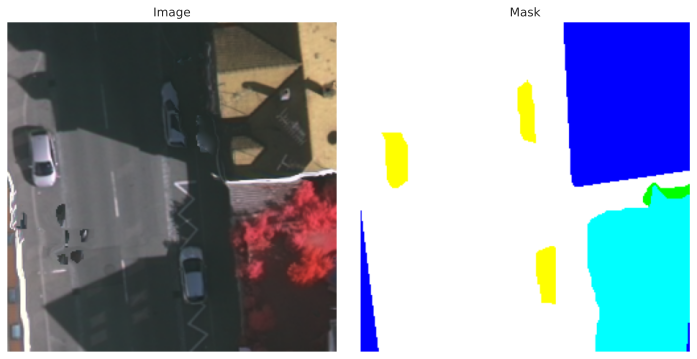

In [24]:
# visualizing the first image with relative mask

def visualize_image(img, mask):
      fig, ax = plt.subplots(1, 2, figsize=(10, 5))
      img = cv2.imread(img)
      mask = cv2.imread(mask)

      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

      ax[0].imshow(img, cmap='gray')
      ax[1].imshow(mask, cmap='gray')
      ax[0].set_title('Image')
      ax[1].set_title('Mask')
      ax[0].axis('off')
      ax[1].axis('off')
      plt.tight_layout()
      plt.show()

visualize_image("./drive/MyDrive/Colab Notebooks/Dataset/train/train_imgs/img1.tif","./drive/MyDrive/Colab Notebooks/Dataset/train/train_masks/mask1.tif")

#Mapping of masks pixel
Given the nature of the masks and the architecture of the convolutional neural network (which requires only one output channel), I mapped each individual pixel from the RGB format to a single value between 0 and 5 (6 being the number of classes), just as it happens in a typical multiclass classification problem. To do this, I used two Python dictionaries with their respective functions that allowed the conversion of images from one form to another, so that I could easily feed the sample to the network and display the result of a prediction on the screen.


In [25]:
target_mapping = {(1, 1, 1) : 0, # Impervious surfaces (RGB: 255, 255, 255)
                  (0, 0, 1) : 1, # Buildings (RGB: 0, 0, 255)
                  (0, 1, 1) : 2, # Low vegetation (RGB: 0, 255, 255)
                  (0, 1, 0) : 3, # Trees (RGB: 0, 255, 0)
                  (1, 1, 0) : 4, # Cars (RGB: 255, 255, 0)
                  (1, 0, 0) : 5, # Clutter (RGB: 255, 0, 0)
                   }

reversed_target_mapping = {v: k for k, v in target_mapping.items()}


def convert_image(tensor):

      converted_tensor = torch.zeros(1, tensor.size(1), tensor.size(2), dtype=torch.long)

      for x in range(tensor.size(1)):
          for y in range(tensor.size(2)):
              pixel_value = tensor[:, x, y]

              for i in range(3):
                  if pixel_value[i] < 0.5:
                      pixel_value[i] = 0
                  else:
                      pixel_value[i] = 1

              color = target_mapping.get(tuple(pixel_value.tolist()), 0)
              converted_tensor[:, x, y] = torch.tensor(color)

      return converted_tensor


def revert_image(tensor):

        converted_tensor = torch.zeros(3, tensor.size(1), tensor.size(2))

        for x in range(tensor.size(1)):
            for y in range(tensor.size(2)):
                pixel_value = tensor[:,x, y]
                color = reversed_target_mapping.get(int(pixel_value), (0, 0, 0))
                converted_tensor[:, x, y] = torch.tensor(color)

        return converted_tensor

#Proof that the two above functions actually work

torch.Size([3, 250, 250])
torch.Size([1, 250, 250])
torch.Size([3, 250, 250])


(-0.5, 249.5, 249.5, -0.5)

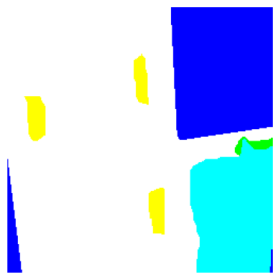

In [26]:
transform = transforms.Compose([transforms.ToTensor()])

mask = transform(Image.open("./drive/MyDrive/Colab Notebooks/Dataset/train/train_masks/mask1.tif").convert("RGB"))
print(mask.shape)
mask = convert_image(mask)
print(mask.shape)
mask = revert_image(mask)
print(mask.shape)
plt.imshow(mask.permute(1,2,0))
plt.axis('off')



In [27]:
BATCH_SIZE = 64
PATCH_SIZE = 96
N_EPOCHS = 100

#Custom PyTorch Dataset
Implemented a custom PyTorch Dataset to handle the image loading.  
***NOTE:***  
The entire dataset is kept in RAM given the not excessive size of the available dataset.

In [28]:
class VaihingenDataset(Dataset):
      def __init__(self, imgs_dir, masks_dir, transform):
         self.transform = transform
         self.imgs_dir = imgs_dir
         self.masks_dir = masks_dir

         self.image_files = sorted(x for x in os.listdir(imgs_dir) if x.endswith(".tif"))
         self.mask_files = sorted(x for x in os.listdir(masks_dir) if x.endswith(".tif"))

         self.imgs = torch.zeros((len(self.image_files), 3, PATCH_SIZE, PATCH_SIZE))
         self.masks = torch.zeros((len(self.mask_files), 1, PATCH_SIZE, PATCH_SIZE), dtype=torch.long)



         for idx in tqdm(range(len(self.image_files))):
            img_path = os.path.join(self.imgs_dir, self.image_files[idx])
            mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("RGB")

            if self.transform:
              image = self.transform(image)
              mask = self.transform(mask)

            self.imgs[idx] = image
            self.masks[idx] = convert_image(mask)

      def __len__(self):
         return len(self.imgs)

      def __getitem__(self, idx):
         return self.imgs[idx], self.masks[idx]


In [29]:
transform = transforms.Compose([
      transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
      transforms.ToTensor()
])


TRAIN_IMGS_PATH = "./drive/MyDrive/Colab Notebooks/Dataset/train/train_imgs"
TRAIN_MASKS_PATH = "./drive/MyDrive/Colab Notebooks/Dataset/train/train_masks"

VAL_IMGS_PATH = "./drive/MyDrive/Colab Notebooks/Dataset/val/val_imgs"
VAL_MASKS_PATH = "./drive/MyDrive/Colab Notebooks/Dataset/val/val_masks"

TEST_IMGS_PATH = "./drive/MyDrive/Colab Notebooks/Dataset/test/test_imgs"
TEST_MASKS_PATH = "./drive/MyDrive/Colab Notebooks/Dataset/test/test_masks"

#Datasets instantiation with Dataloaders and Normalization
In deep learning, image normalization is a crucial preprocessing step that helps in stabilizing the training process and significantly reduces the number of training epochs required. Normalization typically involves scaling the pixel values of images to a small range, usually between 0 and 1, or -1 and 1. This is often done by dividing each pixel value by 255, which is the maximum pixel value for a standard 8-bit image. Another common approach is zero-mean normalization, where you subtract the mean pixel value and divide by the standard deviation, thereby transforming the image data to have a mean of zero and a standard deviation of one.

Normalization helps in achieving a more stable and faster convergence during the training process by ensuring that each feature contributes equally to the model's learning. It also helps in reducing the risk of getting stuck in local minima during the optimization process. This step is particularly important in the context of convolutional neural networks (CNNs) and other deep learning algorithms where small changes in weights can have a significant impact on the final output.

In [30]:
print("---------------------------------")
print("Train Dataset Loading ...")

train_dataset = VaihingenDataset(TRAIN_IMGS_PATH, TRAIN_MASKS_PATH, transform)

print("---------------------------------")
print("Validation Dataset Loading ...")

val_dataset = VaihingenDataset(VAL_IMGS_PATH, VAL_MASKS_PATH, transform)

print("---------------------------------")
print("Test Dataset Loading ...")

test_dataset = VaihingenDataset(TEST_IMGS_PATH, TEST_MASKS_PATH, transform)
print("---------------------------------")

TRAIN_DATASET_MEAN = train_dataset.imgs.mean(axis=(0, 2, 3), keepdims=True)
TRAIN_DATASET_STD = train_dataset.imgs.std(axis=(0, 2, 3), keepdims=True)


# zero-mean normalization of the dataset

train_dataset.imgs = (train_dataset.imgs - TRAIN_DATASET_MEAN) / TRAIN_DATASET_STD
val_dataset.imgs = (val_dataset.imgs - TRAIN_DATASET_MEAN) / TRAIN_DATASET_STD
test_dataset.imgs = (test_dataset.imgs - TRAIN_DATASET_MEAN) / TRAIN_DATASET_STD


# pytorch dataloader for each dataset

train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=True)



---------------------------------
Train Dataset Loading ...


  0%|          | 0/1948 [00:00<?, ?it/s]

---------------------------------
Validation Dataset Loading ...


  0%|          | 0/487 [00:00<?, ?it/s]

---------------------------------
Test Dataset Loading ...


  0%|          | 0/609 [00:00<?, ?it/s]

---------------------------------


#Exploratory Data Analysis (EDA)

The analysis of the training data shows that there is a strong imbalance in the dataset regarding cars and clutters (the latter is not a problem as it is not the intention of the task to identify them). This issue will be addressed by choosing a weighted loss module, but the model will be weak on these classes.


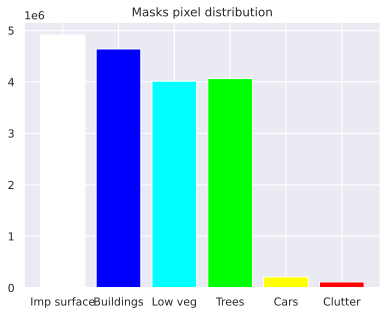

In [31]:
class_counts = torch.bincount(train_dataset.masks.flatten())
colors = list(target_mapping.keys())
plt.bar(["Imp surface", "Buildings", "Low veg", "Trees", "Cars", "Clutter"], class_counts, color=colors)
plt.title("Masks pixel distribution")
plt.show()

#U-Net's architecture

U-Net is designed for semantic segmentation in medical image analysis and other areas. It's built upon an encoder-decoder structure and features a distinctive "U"-shaped topology. The encoder portion consists of a series of convolutional layers followed by max-pooling layers for downsampling, successively reducing the spatial dimensions while increasing the depth (i.e., number of feature channels). As the encoder processes the input image, it captures increasingly abstract representations of the data.

The decoder portion of the U-Net performs the opposite operation: it upsamples the abstract representations and uses convolutional layers to generate an output with the same dimensions as the original input image. Crucially, U-Net introduces skip connections between the encoder and decoder modules. These connections pass information from each layer in the encoder to its corresponding layer in the decoder, allowing the network to consider features at multiple levels of abstraction when making its predictions.

The output layer of the U-Net generally consists of a softmax activation function that assigns each pixel to a particular class, making it well-suited for segmentation tasks. Overall, the architecture allows for efficient training and high performance on tasks requiring the delineation of complex shapes.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="700">

In [32]:
import torchvision.transforms.functional as TF


class DoubleConvolution(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):

    def __init__(self, input_channels=3, output_channels=6,
                 features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for f in features:
            self.downs.append(DoubleConvolution(input_channels, f))
            input_channels = f

        # lower bottleneck layers
        self.bottleneck = DoubleConvolution(features[-1], features[-1] * 2)

        # Decoder
        for f in reversed(features):
            self.ups.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_channels=2 * f, out_channels=f, kernel_size=3,
                              padding=1),
                ))
            self.ups.append(DoubleConvolution(2 * f, f))

        self.final_convolution = nn.Conv2d(in_channels=features[0],
                                           out_channels=output_channels,
                                           kernel_size=3, padding=1)

    def forward(self, x):
        skip_connections = list()
        for module in self.downs:
            x = module(x)
            skip_connections.append(x)
            x = self.pool(x)

        skip_connections = skip_connections[::-1]  # reverse order

        x = self.bottleneck(x)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:],
                              interpolation=TF.InterpolationMode.NEAREST)
            x = torch.cat([skip_connection, x], dim=1)
            x = self.ups[i + 1](x)

        x = self.final_convolution(x)

        return x

In [33]:
def train(model, optimizer, data_loader, loss_module, n_epochs=50):



    train_loss_list = []
    val_loss_list = []
    epoch_list = []


    for epoch in range(1,n_epochs + 1):
        model.train()
        training_loss = 0.0

        for data_inputs,data_labels in data_loader:

            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            preds = model(data_inputs)
            preds = preds.squeeze(dim = 1)
            loss = loss_module(preds, data_labels.squeeze(1))

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            training_loss += loss.data.item() * data_inputs.size(0)

        training_loss /= len(data_loader.dataset)


        train_loss_list.append(training_loss)
        epoch_list.append(epoch)
        val_loss, _, _ = eval(model,val_dataloader,loss_module)
        val_loss_list.append(val_loss)
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {}'.format(epoch, training_loss, val_loss))

        torch.save(model.state_dict(), "model_checkpoint_"+str(epoch - 1)+".tar")

    return model, optimizer, train_loss_list, val_loss_list, epoch_list

In [34]:
def eval(model, data_loader, loss_module):

  model.eval()
  test_loss = 0.0
  num_correct = 0
  num_examples = 0
  predicted_labels = []
  true_labels = []

  with torch.no_grad():
    for data_inputs, data_labels in data_loader:

        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

        preds = model(data_inputs)
        preds.squeeze(dim = 1)

        loss = loss_module(preds, data_labels.squeeze(1))
        test_loss += loss.data.item() * data_inputs.size(0)

        _, predicted = torch.max(preds, dim=1)
        predicted_labels.extend(predicted.cpu())
        true_labels.extend(data_labels.cpu())

  test_loss = test_loss / len(data_loader.dataset)


  return test_loss, predicted_labels, true_labels


In [35]:
class_weights = 1.0 / class_counts.float()
class_weights /= torch.sum(class_weights)
class_weights = class_weights.to(device)

print(class_weights)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

tensor([0.0139, 0.0148, 0.0171, 0.0168, 0.3267, 0.6107], device='cuda:0')


In [36]:
models = []
val_losses = []
learning_rates = [0.0001, 0.00001, 0.01]

for i,lr in enumerate(learning_rates):
    print("-----------------------------------")
    print(f"Model number {i+1}:")
    model = UNet(input_channels=3, output_channels=6)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model, optimizer, train_loss_list, val_loss_list, epoch_list = train(model, optimizer, train_dataloader, loss_fn, n_epochs=N_EPOCHS)
    val_loss = min(val_loss_list)
    state_dict = torch.load("model_checkpoint_"+str(np.argmin(val_loss_list))+".tar")
    model.load_state_dict(state_dict)
    print("Validation loss: {}".format(val_loss))
    val_losses.append(val_loss)
    models.append(model)

best_model = models[np.argmin(val_losses)]

-----------------------------------
Model number 1:
Epoch: 1, Training Loss: 1.2853, Validation Loss: 1.2939880680009814
Epoch: 2, Training Loss: 0.9312, Validation Loss: 0.9231883669291189
Epoch: 3, Training Loss: 0.8206, Validation Loss: 0.8530862299568599
Epoch: 4, Training Loss: 0.7781, Validation Loss: 0.8653388793218797
Epoch: 5, Training Loss: 0.7168, Validation Loss: 0.7539444196150777
Epoch: 6, Training Loss: 0.6702, Validation Loss: 0.8021402240289065
Epoch: 7, Training Loss: 0.6655, Validation Loss: 0.8582445866518197
Epoch: 8, Training Loss: 0.6184, Validation Loss: 0.7486725041998485
Epoch: 9, Training Loss: 0.5913, Validation Loss: 0.6264234766578283
Epoch: 10, Training Loss: 0.5809, Validation Loss: 0.7555681534371582
Epoch: 11, Training Loss: 0.5590, Validation Loss: 0.7029942614341909
Epoch: 12, Training Loss: 0.5307, Validation Loss: 0.7124418235657396
Epoch: 13, Training Loss: 0.4944, Validation Loss: 0.6444537927237869
Epoch: 14, Training Loss: 0.5065, Validation Lo

Test loss: 0.4322089802455432


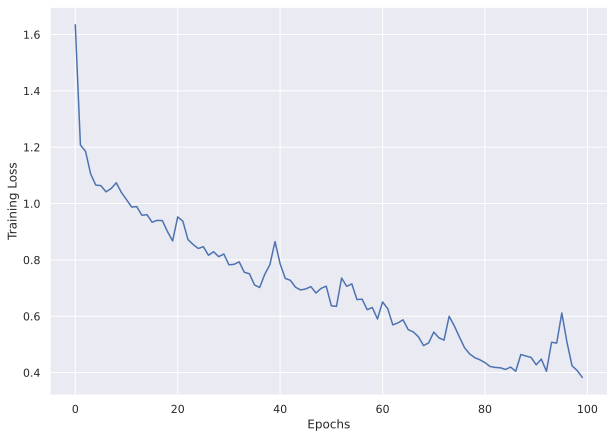

In [37]:
test_loss, predicted_labels_val, true_labels_val = eval(best_model, test_dataloader, loss_fn)
print("Test loss: {}".format(test_loss))

for i in range (len(true_labels_val)):
    true_labels_val[i] = true_labels_val[i].numpy()
for i in range (len(predicted_labels_val)):
    predicted_labels_val[i] = predicted_labels_val[i].numpy()

true_labels_val = np.array(true_labels_val)
true_labels_val = np.squeeze(true_labels_val)


predicted_labels_val = np.array(predicted_labels_val).flatten()
true_labels_val = np.array(true_labels_val).flatten()

plt.figure(figsize=(10, 7))
plt.plot(train_loss_list)

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()


Accuracy: 0.8203477781198686
Precision: 0.8375873630926677
Recall: 0.8203477781198686
F1: 0.8256224290475993
              precision    recall  f1-score   support

           0       0.86      0.82      0.84   1582122
           1       0.94      0.84      0.89   1479069
           2       0.73      0.75      0.74   1112380
           3       0.83      0.85      0.84   1286086
           4       0.39      0.87      0.54     76107
           5       0.43      0.92      0.59     76780

    accuracy                           0.82   5612544
   macro avg       0.70      0.84      0.74   5612544
weighted avg       0.84      0.82      0.83   5612544



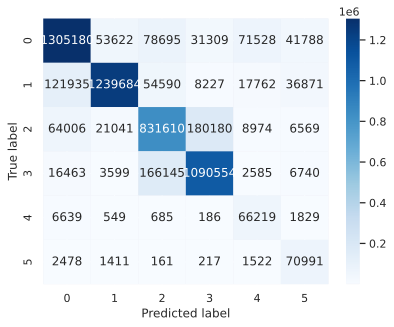

In [38]:
# Several Metrics
print("Accuracy:", accuracy_score(true_labels_val, predicted_labels_val))
print("Precision:", precision_score(true_labels_val, predicted_labels_val, average='weighted'))
print("Recall:", recall_score(true_labels_val, predicted_labels_val, average='weighted'))
print("F1:", f1_score(true_labels_val, predicted_labels_val, average='weighted'))

# Confusion matrix
cm = confusion_matrix(true_labels_val, predicted_labels_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')


# Classification report
print(classification_report(true_labels_val, predicted_labels_val))

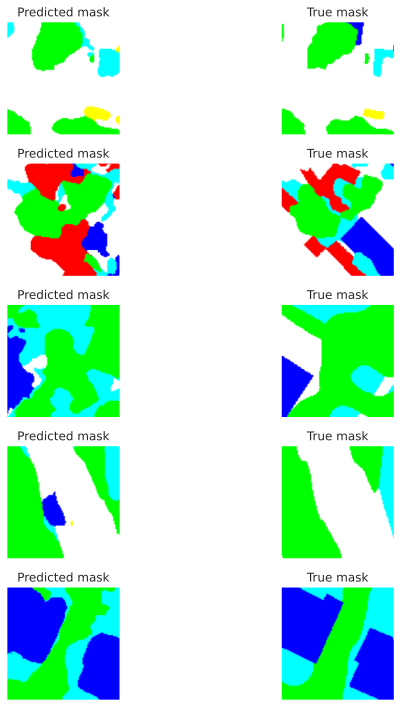

In [39]:
fig, ax = plt.subplots(5, 2, figsize = (10,10))

for i in range(5):
  pred1 = predicted_labels_val.reshape(-1,1,96,96)
  pred = revert_image(torch.tensor(pred1[40 + i]))
  true1 = true_labels_val.reshape(-1,1,96,96)
  true = revert_image(torch.tensor(true1[40 + i]))

  ax[i][0].imshow(pred.permute(1,2,0))
  ax[i][1].imshow(true.permute(1,2,0))

  ax[i][0].set_title("Predicted mask")
  ax[i][1].set_title("True mask")

  ax[i][0].axis('off')
  ax[i][1].axis('off')

plt.tight_layout()
plt.show()

